In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def emission_height(P, hmin, hmax, npatch):
    """Function to determine the emission height range given hmin and hmax. Allowed emision heights for young 
       pulsars range between [950, 1000] and between [20, 1000] for old pulsars.
    
       Args:
       -----
       P      : rotational period.
       hmin   : minimum emission height (in km).
       hmax   : maximum emission height (in km).
       npatch : integer number of emission patches.
       
       Returns:
       --------
       H      : random emission height.
    """
    
    #num_H = np.random.randint(3,8)  # random number of discrete emission height 
    num_H = npatch
    #np.random.seed(0)  # makes the random numbers predictable; the same numbers appear every time.
    
#   emission height for a short period pulsar: only one emission height 
    if P <= 0.15:
        if hmin >= 950 and hmax <= 1000:
            H = np.random.uniform(hmin, hmax)
            
        else: print "error, emission range not allowed for pulse period P < 0.15 seconds"
            
#   emission height for a long period pulsar:        
    if P > 0.15:
        if hmin >= 20 and hmax <= 1000:
            H = np.random.uniform(hmin, hmax, size=num_H)
        
        else: print "error, emission range not allowed for pulse period P > 0.15 seconds"
        
    return H

########################### simple test #############################
if __name__ == "__main__":
    P = 0.16
    hmin = 50
    hmax = 950
    npatch = 3
    H = emission_height(P, hmin, hmax, npatch)
    print H  

[  51.02644627  476.09951645  457.37277693]


In [3]:
import mapphi as mp
def los(alpha, beta):
    """Function to determine the line of sight cut across the beam.
    
       Args:
       -----
       alpha       : inclination angle
       beta        : impact parameter
       
       Returns:
       --------
       xlos        : the line of sight x-coordinates
       ylos        : the line of sight y-coordinates
       avgthetalos : the line of sight angle in degrees
    """
    
    phi = np.arange(-180,180)
    xlos, ylos = mp.mapphi(alpha, beta, phi)
    thetalos = np.arctan2(ylos, xlos) * (180 / np.pi) - 90.0
    for i in np.arange(len(thetalos)):
        if thetalos[i] < 0:
            thetalos[i] = -thetalos[i]
            
#   find the average thetalos
    avgthetalos = np.average(thetalos)
    
    return xlos, ylos, avgthetalos
################## test ######################
if __name__ == "__main__":
    alpha = 90
    beta = 30
    xlos, ylos, avgthetalos = los(alpha, beta)
    print avgthetalos, xlos

89.8967204028 [ 28.65154817  28.65154816  28.65154813  28.65154808  28.651548
  28.65154791  28.65154779  28.65154765  28.65154749  28.65154731
  28.65154711  28.65154689  28.65154665  28.65154638  28.6515461
  28.6515458   28.65154547  28.65154513  28.65154476  28.65154437
  28.65154397  28.65154354  28.6515431   28.65154263  28.65154214
  28.65154164  28.65154112  28.65154057  28.65154001  28.65153943
  28.65153883  28.65153822  28.65153758  28.65153693  28.65153626
  28.65153557  28.65153486  28.65153414  28.6515334   28.65153265
  28.65153187  28.65153108  28.65153028  28.65152946  28.65152862
  28.65152777  28.65152691  28.65152603  28.65152513  28.65152422
  28.6515233   28.65152236  28.65152142  28.65152045  28.65151948
  28.65151849  28.65151749  28.65151648  28.65151546  28.65151443
  28.65151338  28.65151233  28.65151126  28.65151019  28.65150911
  28.65150801  28.65150691  28.6515058   28.65150468  28.65150356
  28.65150243  28.65150129  28.65150014  28.65149899  28.65149783

In [27]:
from scipy import constants
#import emission_height

def rho(P, hmin, hmax):
    """Function to determine the opening angle rho given the rotational period and emission height.
       
    
       Args:
       -----
       P   : rotational period (seconds)
       H   : emission height (km)
       
       Returns:
       --------
       rho : the opening angle (degrees)
       
    """
    
    H = emission_height(P, hmin, hmax, npatch)
    print H
    rho = np.rad2deg(np.sqrt((9 * np.pi * H) / (2 * (constants.c / 1000) * P)))   
    #rho = np.sqrt((9 * np.pi * H) / (2 * constants.c * P))
    return rho

#################### simple test #####################################
if __name__ == "__main__":
    P = 0.16
    hmin = 50
    hmax = 950
    npatch = 3
    opa = rho(P, hmin, hmax)
    print opa

[ 140.11580018  322.47777703  114.20763836]
[ 11.64332549  17.66376908  10.51189607]


In [5]:
def patch_width(P, hmin, hmax, npatch):
    """Function to calculate the width of a patchy emission region 
       within a pulsar beam at a given height.
    
       Args:
       -----
       P             : rotational period (seconds).
       hmin          : minimum emission height (in km).
       hmax          : maximum emission height (in km).
       npatch        : integer number of emission patches.
       
       Returns:
       --------
       patchwidths   : the width of the patchy emission region (degrees).
11.64332549  17.66376908  10.51189607]
    """   
    
    H = emission_height(P, hmin, hmax, npatch)
    patchwidths = 2.45 * 0.2 * np.sqrt(H / ( 10 * P)) 
    
    return patchwidths
#################### simple test ################################################
if __name__ == "__main__":
    P = 0.16
    hmin = 50
    hmax = 950
    npatch = 3
    patchwidths = patch_width(P, hmin, hmax, npatch)
    print patchwidths



[ 11.92039251   9.92821944   6.45043111]


In [31]:
def patch_center(P, hmin, hmax, npatch):
    """Function find centres of the patches
       
       Args:
       -----
       P      : rotatinal period
       hmin   : minimum emission height (in km).
       hmax   : maximum emission height (in km).
       npatch : number of emission patches
       
       
       Returns:
       --------
       patch_centerx : the patch center projection on the x-axis 
       patch_centery : the patch center projection on the y-axis 
    """
#   centers of the patches in the rotational plane (x,y coords):
#    np.random.seed(0)
    patch_center = 2 * np.pi * np.random.random(npatch) 
    patch_centerx = np.zeros(npatch)
    patch_centery = np.zeros(npatch)
    
    theta = patch_center
    opa = rho(P, hmin, hmax)  # opening angle of the beam (rho in degrees)
#    print len(opa), opa

#   for short periods 
    if P <= 0.15:
        if hmin >= 950 and hmax <= 1000:
            for i in np.arange(npatch):
                patch_centerx[i] = opa * np.sin(patch_center[i])
                patch_centery[i] = opa * np.cos(patch_center[i])
                
#   for longer periods
    if P > 0.15:
        if hmin >= 20 and hmax <= 1000:
            for i in np.arange(npatch):
                patch_centerx[i] = opa[i] * np.sin(patch_center[i])
                patch_centery[i] = opa[i] * np.cos(patch_center[i])
        
    return patch_centerx, patch_centery, theta

########################### simple test ###########################
if __name__ == "__main__":
    P = 0.16
    hmin = 50
    hmax = 950
    npatch = 3
    cx, cy, theta= patch_center(P, hmin, hmax, npatch)
    print cx, cy 

[ 495.53701309  369.68829445  395.35369122]
[-10.04339572  -4.97021782  12.74076296] [-19.45713023  18.24783633  14.83885914]


[ 906.33305667  851.07027056  321.59983798  289.09625791  590.32242845]
[-23.99265685  28.55262599   9.98512705 -16.71754658  18.93503757] [-17.35689891  -2.86153051 -14.54154526   0.48431945 -14.58157513] 1.57079632679
(5, 500, 500)


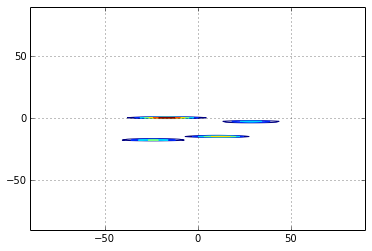

In [51]:
import d2r
def plotpatch(P, alpha, beta, hmin, hmax, npatch):
    """Function to plot the patches for a given height range. Using a 2d gaussian
    
       Args:
       -----
       P       : rotational period (seconds)
       alpha   : inclination angle (degrees)
       beta    : impact parameter (degrees)
       hmin    : minimum emission height (in km)
       hmax    : maximum emission height (in km)
       npatch  : number of emission patches
       
       Returns:
       --------
       A plot of the patches projected on to observational plane.
    
    """    
    
#   make a 2D array:
    x = np.linspace(-180, 180, num=500, endpoint=True)
    y = np.linspace(-180, 180, num=500, endpoint=True)
    X,Y = np.meshgrid(x,y)

#   patchcenter or mean of the plot from patch center:
    cx, cy, theta = patch_center(P, hmin, hmax, npatch)
    print cx, cy, theta

#   choose random patch widths (wp) depending on how are patches specified:
    patchwidths = patch_width(P, hmin, hmax, npatch)
    #np.random.shuffle(patchwidths)
    if npatch > 1:
        np.random.shuffle(patchwidths)
        wp = patchwidths[0:npatch]

    if npatch == 1:
        wp = patchwidths 
    

#   wp == the spread (sigma)
#   project the sigmax and sigmay to the line of sight plane:
    #xlos, ylos, thetalos = los(alpha, beta)
    #thet = 5
    #theta = 2 * np.pi * np.random.random(npatch)
    sigmax = wp * d2r.sinD(theta)
    sigmay = wp * d2r.cosD(theta)
    
    
#   2D gaussian:
    peak = 5 # trial peak 
    a = ((np.cos(theta) ** 2) / (2 * sigmax ** 2)) + ((np.sin(theta) ** 2) / (2 * sigmay ** 2))
    b = (-(np.sin(2 * theta)) / (4 * sigmax ** 2)) + ((np.sin(2 * theta)) / (4 * sigmay ** 2))
    c = ((np.sin(theta) ** 2) / (2 * sigmax ** 2)) + ((np.cos(theta) ** 2) / (2 * sigmay ** 2))
    
    Z = []
    if npatch > 1:
        for i in np.arange(len(cx)):
            #Z = peak * np.exp(-(a[i] * (X - cx[i]) ** 2 - 2 * b[i] * (X - cx[i]) * (Y - cy[i]) + c[i] * (Y - cy[i]) ** 2))
            Z.append(peak * np.exp(-(a[i] * (X - cx[i]) ** 2 - 2 * b[i] * (X - cx[i]) * (Y - cy[i]) + c[i] * (Y - cy[i]) ** 2)))

    if npatch == 1:
        Z = peak * np.exp(-(a * (X - cx) ** 2 - 2 * b * (X - cx) * (Y - cy) + c * (Y - cy) ** 2)) 
    
#    if npatch == 0:
#        Z = peak * np.exp(-(a * X ** 2 - 2 * b * X * Y + c * Y ** 2)) 


    #for i in np.arange(len(Z)):
    print np.array(Z).shape
    for i in np.arange(1):
        fig1 = plt.figure() # reason for multiple plots    
        plt.contour(X, Y, np.sum(np.array(Z), axis=0))
        plt.xlim(-90, 90)
        plt.ylim(-90, 90)
        plt.grid()
        #plt.hold(True)
        #fig2 = plt.figure()
        #plt.grid()
        #plt.imshow(Z[i])  
    
    
############################ simple test ##########################
if __name__ == "__main__":
    P = 0.16
    hmin = 50
    hmax = 950
    npatch = 5
    alpha = 10
    beta = 1
    plotpatch(P, alpha, beta, hmin, hmax, npatch)

In [50]:
2 * np.pi * np.random.random()

2.0293992862490144